Zaimplementuj aplikację szacującą czas ukończenia półmaratonu dla zadanych danych

1. Umieść dane w Digital Ocean Spaces

1. Napisz notebook, który będzie Twoim pipelinem do trenowania modelu
    * czyta dane z Digital Ocean Spaces
    * czyści je
    * trenuje model (dobierz odpowiednie metryki [feature selection])
    * nowa wersja modelu jest zapisywana lokalnie i do Digital Ocean Spaces

1. Aplikacja
    * opakuj model w aplikację streamlit
    * wdróż (deploy) aplikację za pomocą Digital Ocean AppPlatform 
    * wejściem jest pole tekstowe, w którym użytkownik się przedstawia, mówi o tym
    jaka jest jego płeć, wiek i tempo na 5km
    * jeśli użytkownik podał za mało danych, wyświetl informację o tym jakich danych brakuje
    * za pomocą LLM (OpenAI) wyłuskaj potrzebne dane, potrzebne dla Twojego modelu
    do określenia, do słownika (dictionary lub JSON)
    * tę część podepnij do Langfuse, aby zbierać metryki o skuteczności działania LLM'a



In [27]:
# Snippet pomocniczy - zmiana czasu na sekundy

import pandas as pd
from dotenv import load_dotenv
import boto3
import os
from pycaret.regression import setup, compare_models, finalize_model, plot_model, save_model, load_model, predict_model
from sklearn.preprocessing import LabelEncoder



In [4]:
load_dotenv()

True

In [5]:
s3 = boto3.client(
    "s3",)

In [6]:
BUCKET_NAME = "maratonapp"

In [7]:
# Wyślijmy teraz wszystkie pliki z danymi z giełdy do Cloud Storage
for root, dirs, files in os.walk("data"):
    for file in files:
        file_path = os.path.join(root, file)
        s3_path = file_path.replace("\\","/").replace("data/", "data/")
        print(f"Wysyłam plik {os.path.join(root, file)} do {s3_path}") 
        s3.upload_file(
            Filename=file_path,
            Bucket=BUCKET_NAME,
            Key=s3_path
        )

Wysyłam plik data\halfmarathon_wroclaw_2023__final.csv do data/halfmarathon_wroclaw_2023__final.csv
Wysyłam plik data\halfmarathon_wroclaw_2024__final.csv do data/halfmarathon_wroclaw_2024__final.csv
Wysyłam plik data\halfmaraton23_24.csv do data/halfmaraton23_24.csv


In [8]:
df1 = pd.read_csv(f"s3://{BUCKET_NAME}/data/halfmarathon_wroclaw_2023__final.csv", sep=';')
df2 = pd.read_csv(f"s3://{BUCKET_NAME}/data/halfmarathon_wroclaw_2024__final.csv", sep=';')

df = pd.concat([df1, df2], ignore_index=True)
df

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2.926667,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.983333,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.123333,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,3.196667,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,3.276667,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21952,NaN,6445,ANNA,ŻUROWSKA,NaN,NaN,NaN,K,NaN,K40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNS,NaN
21953,NaN,23495,JUSTYNA,ŻYGADŁO,NaN,NaN,NaN,K,NaN,K20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21954,NaN,9323,DAWID,ŻYTKOWSKI,NaN,NaN,NaN,M,NaN,M20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNS,NaN
21955,NaN,27386,DOMINIKA,ĆWIERTNIA,NaN,NaN,NaN,K,NaN,K30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Snippet pomocniczy - zmiana czasu na sekundy

def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

In [10]:
df['Czas'] = df['Czas'].apply(convert_time_to_seconds)

In [11]:
# 
df['Czas'].head()


0    3899.0
1    3983.0
2    4104.0
3    4216.0
4    4227.0
Name: Czas, dtype: float64

In [12]:
df

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2.926667,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,3899.0,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.983333,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,3983.0,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.123333,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,4104.0,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,3.196667,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,4216.0,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,3.276667,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,4227.0,3.339654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21952,NaN,6445,ANNA,ŻUROWSKA,NaN,NaN,NaN,K,NaN,K40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21953,NaN,23495,JUSTYNA,ŻYGADŁO,NaN,NaN,NaN,K,NaN,K20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21954,NaN,9323,DAWID,ŻYTKOWSKI,NaN,NaN,NaN,M,NaN,M20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21955,NaN,27386,DOMINIKA,ĆWIERTNIA,NaN,NaN,NaN,K,NaN,K30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.to_csv('halfmaraton23_24.csv', index=False)

In [14]:
df = pd.read_csv(f"s3://{BUCKET_NAME}/data/halfmaraton23_24.csv", sep=',')
df

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2.926667,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,3899.0,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.983333,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,3983.0,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.123333,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,4104.0,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,3.196667,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,4216.0,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,3.276667,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,4227.0,3.339654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21952,NaN,6445,ANNA,ŻUROWSKA,NaN,NaN,NaN,K,NaN,K40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21953,NaN,23495,JUSTYNA,ŻYGADŁO,NaN,NaN,NaN,K,NaN,K20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21954,NaN,9323,DAWID,ŻYTKOWSKI,NaN,NaN,NaN,M,NaN,M20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21955,NaN,27386,DOMINIKA,ĆWIERTNIA,NaN,NaN,NaN,K,NaN,K30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df


,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2.926667,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,3899.0,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.983333,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,3983.0,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.123333,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,4104.0,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,3.196667,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,4216.0,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,3.276667,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,4227.0,3.339654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21952,NaN,6445,ANNA,ŻUROWSKA,NaN,NaN,NaN,K,NaN,K40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21953,NaN,23495,JUSTYNA,ŻYGADŁO,NaN,NaN,NaN,K,NaN,K20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21954,NaN,9323,DAWID,ŻYTKOWSKI,NaN,NaN,NaN,M,NaN,M20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21955,NaN,27386,DOMINIKA,ĆWIERTNIA,NaN,NaN,NaN,K,NaN,K30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# pokaz wszytskie kolumny
pd.set_option('display.max_columns', None)

In [17]:
df


,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,Kategoria wiekowa Miejsce,Rocznik,5 km Czas,5 km Miejsce Open,5 km Tempo,10 km Czas,10 km Miejsce Open,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,1.0,1992.0,00:14:37,1.0,2.923333,00:29:15,1.0,2.926667,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,3899.0,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,2.0,1986.0,00:14:48,2.0,2.960000,00:29:43,2.0,2.983333,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,3983.0,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,1.0,1996.0,00:15:46,4.0,3.153333,00:31:23,3.0,3.123333,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,4104.0,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,3.0,1988.0,00:16:11,6.0,3.236667,00:32:10,5.0,3.196667,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,4216.0,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,2.0,1995.0,00:16:12,7.0,3.240000,00:32:35,7.0,3.276667,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,4227.0,3.339654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21952,NaN,6445,ANNA,ŻUROWSKA,NaN,NaN,NaN,K,NaN,K40,NaN,1982.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21953,NaN,23495,JUSTYNA,ŻYGADŁO,NaN,NaN,NaN,K,NaN,K20,NaN,1998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21954,NaN,9323,DAWID,ŻYTKOWSKI,NaN,NaN,NaN,M,NaN,M20,NaN,1995.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21955,NaN,27386,DOMINIKA,ĆWIERTNIA,NaN,NaN,NaN,K,NaN,K30,NaN,1991.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.isna().sum()

Miejsce                       3507
Numer startowy                   0
Imię                             0
Nazwisko                         0
Miasto                        4183
Kraj                          3507
Drużyna                      13555
Płeć                            11
Płeć Miejsce                  3507
Kategoria wiekowa               31
Kategoria wiekowa Miejsce     3527
Rocznik                        485
5 km Czas                     3546
5 km Miejsce Open             3546
5 km Tempo                    3546
10 km Czas                    3530
10 km Miejsce Open            3530
10 km Tempo                   3562
15 km Czas                    3529
15 km Miejsce Open            3529
15 km Tempo                   3544
20 km Czas                    3518
20 km Miejsce Open            3518
20 km Tempo                   3535
Tempo Stabilność              3580
Czas                          3507
Tempo                         3507
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21957 entries, 0 to 21956
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Miejsce                    18450 non-null  float64
 1   Numer startowy             21957 non-null  int64  
 2   Imię                       21957 non-null  object 
 3   Nazwisko                   21957 non-null  object 
 4   Miasto                     17774 non-null  object 
 5   Kraj                       18450 non-null  object 
 6   Drużyna                    8402 non-null   object 
 7   Płeć                       21946 non-null  object 
 8   Płeć Miejsce               18450 non-null  float64
 9   Kategoria wiekowa          21926 non-null  object 
 10  Kategoria wiekowa Miejsce  18430 non-null  float64
 11  Rocznik                    21472 non-null  float64
 12  5 km Czas                  18411 non-null  object 
 13  5 km Miejsce Open          18411 non-null  flo

In [20]:
df['5 km Czas'] = df['5 km Czas'].apply(convert_time_to_seconds)

In [21]:
df

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,Kategoria wiekowa Miejsce,Rocznik,5 km Czas,5 km Miejsce Open,5 km Tempo,10 km Czas,10 km Miejsce Open,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,1.0,1992.0,877.0,1.0,2.923333,00:29:15,1.0,2.926667,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,3899.0,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,2.0,1986.0,888.0,2.0,2.960000,00:29:43,2.0,2.983333,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,3983.0,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,1.0,1996.0,946.0,4.0,3.153333,00:31:23,3.0,3.123333,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,4104.0,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,3.0,1988.0,971.0,6.0,3.236667,00:32:10,5.0,3.196667,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,4216.0,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,2.0,1995.0,972.0,7.0,3.240000,00:32:35,7.0,3.276667,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,4227.0,3.339654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21952,NaN,6445,ANNA,ŻUROWSKA,NaN,NaN,NaN,K,NaN,K40,NaN,1982.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21953,NaN,23495,JUSTYNA,ŻYGADŁO,NaN,NaN,NaN,K,NaN,K20,NaN,1998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21954,NaN,9323,DAWID,ŻYTKOWSKI,NaN,NaN,NaN,M,NaN,M20,NaN,1995.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21955,NaN,27386,DOMINIKA,ĆWIERTNIA,NaN,NaN,NaN,K,NaN,K30,NaN,1991.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df.dropna(subset=['Czas'], inplace=True)
df.dropna(subset=['5 km Czas'], inplace=True)

In [23]:
df

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,Kategoria wiekowa Miejsce,Rocznik,5 km Czas,5 km Miejsce Open,5 km Tempo,10 km Czas,10 km Miejsce Open,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,1.0,1992.0,877.0,1.0,2.923333,00:29:15,1.0,2.926667,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,3899.0,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,2.0,1986.0,888.0,2.0,2.960000,00:29:43,2.0,2.983333,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,3983.0,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,1.0,1996.0,946.0,4.0,3.153333,00:31:23,3.0,3.123333,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,4104.0,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,3.0,1988.0,971.0,6.0,3.236667,00:32:10,5.0,3.196667,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,4216.0,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,2.0,1995.0,972.0,7.0,3.240000,00:32:35,7.0,3.276667,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,4227.0,3.339654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19245,10298.0,898,EWA KATARZYNA,KASIERSKA,POZNAŃ,POL,WKB META LUBLINIEC,K,3059.0,K70,6.0,1948.0,2610.0,10344.0,8.700000,01:28:06,10321.0,8.920000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11987.0,9.470649
19246,10299.0,10456,MAGDALENA,PRYNDA,NaN,POL,NaN,K,3060.0,K40,1030.0,1978.0,2526.0,10337.0,8.420000,01:27:34,10318.0,9.093333,02:15:28,10301.0,9.580000,03:10:19,10303.0,10.970000,0.162733,12068.0,9.534645
19247,10300.0,11311,HELENA,KOLANY,WROCŁAW,POL,PARKRUN WROCŁAW,K,3061.0,K60,48.0,1955.0,2960.0,10352.0,9.866667,01:38:19,10329.0,9.796667,02:23:22,10303.0,9.010000,03:11:34,10304.0,9.640000,-0.029333,12138.0,9.589950
19248,10301.0,8404,JOANNA,KAJDANEK,KATY WROCLAWSKIE,POL,.,K,3062.0,K40,1031.0,1981.0,2808.0,10350.0,9.360000,01:36:09,10328.0,9.870000,02:26:03,10304.0,9.980000,03:17:25,10305.0,10.273333,0.057000,12512.0,9.885439


In [25]:
exp = setup(data=df, target="Czas", session_id=123)

,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(18411, 27)"
4,Transformed data shape,"(18411, 39)"
5,Transformed train set shape,"(12887, 39)"
6,Transformed test set shape,"(5524, 39)"
7,Numeric features,16
8,Categorical features,10
9,Rows with missing values,61.9%


In [26]:
best_model_first = exp.compare_models(sort="R2")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0002,0.0000,0.0002,1.0000,0.0000,0.0000,0.4450
ridge,Ridge Regression,1.4557,9.2949,2.9592,1.0000,0.0004,0.0002,0.0500
rf,Random Forest Regressor,1.2132,230.3081,11.2113,0.9999,0.0013,0.0001,1.4910
dt,Decision Tree Regressor,1.6007,301.9569,13.6558,0.9998,0.0015,0.0002,0.0750
gbr,Gradient Boosting Regressor,9.8980,292.7242,16.2628,0.9998,0.0021,0.0013,0.7080
llar,Lasso Least Angle Regression,13.2033,800.4110,28.2334,0.9995,0.0037,0.0017,0.0500
lightgbm,Light Gradient Boosting Machine,7.7355,933.8742,27.5094,0.9994,0.0039,0.0010,0.0890
lasso,Lasso Regression,16.5416,1220.8056,34.8071,0.9992,0.0045,0.0022,0.3210
ada,AdaBoost Regressor,80.2266,10410.3441,101.9115,0.9931,0.0150,0.0113,0.3410
et,Extra Trees Regressor,54.6998,43020.8430,205.5003,0.9715,0.0220,0.0063,0.7090


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [28]:
df['wiek'] = 2023 - df['Rocznik']

In [29]:
le = LabelEncoder()
df['płeć_encoded'] = le.fit_transform(df['Płeć'])

In [30]:
df_model = df[['płeć_encoded', 'wiek', '5 km Tempo', 'Czas']].dropna()

In [31]:
df_model

,płeć_encoded,wiek,5 km Tempo,Czas
0,1,31.0,2.923333,3899.0
1,1,37.0,2.960000,3983.0
2,1,27.0,3.153333,4104.0
3,1,35.0,3.236667,4216.0
4,1,28.0,3.240000,4227.0
...,...,...,...,...
19244,0,46.0,7.986667,11866.0
19245,0,75.0,8.700000,11987.0
19246,0,45.0,8.420000,12068.0
19247,0,68.0,9.866667,12138.0


In [34]:
exp2 = setup(data=df_model, target="Czas", numeric_features=["wiek", "płeć_encoded", "5 km Tempo"], session_id=123)

,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17927, 4)"
4,Transformed data shape,"(17927, 4)"
5,Transformed train set shape,"(12548, 4)"
6,Transformed test set shape,"(5379, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


In [35]:
best_model = exp2.compare_models(sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,298.8600,170220.0652,412.1920,0.8836,0.0522,0.0391,0.0530
lightgbm,Light Gradient Boosting Machine,302.4336,173878.0604,416.6175,0.8811,0.0528,0.0396,0.0150
lasso,Lasso Regression,300.9307,177226.4062,420.4141,0.8790,0.0526,0.0393,0.2170
ridge,Ridge Regression,300.9339,177228.6875,420.4160,0.8790,0.0526,0.0393,0.0060
lar,Least Angle Regression,300.9305,177228.7219,420.4158,0.8790,0.0526,0.0393,0.0050
llar,Lasso Least Angle Regression,300.9307,177226.4219,420.4141,0.8790,0.0526,0.0393,0.0050
omp,Orthogonal Matching Pursuit,300.8259,177175.7422,420.3514,0.8790,0.0526,0.0393,0.0060
br,Bayesian Ridge,300.9314,177228.6969,420.4159,0.8790,0.0526,0.0393,0.0080
lr,Linear Regression,300.9304,177228.7250,420.4158,0.8790,0.0526,0.0393,0.3970
huber,Huber Regressor,296.5553,179613.7270,423.2453,0.8773,0.0528,0.0384,0.0170


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

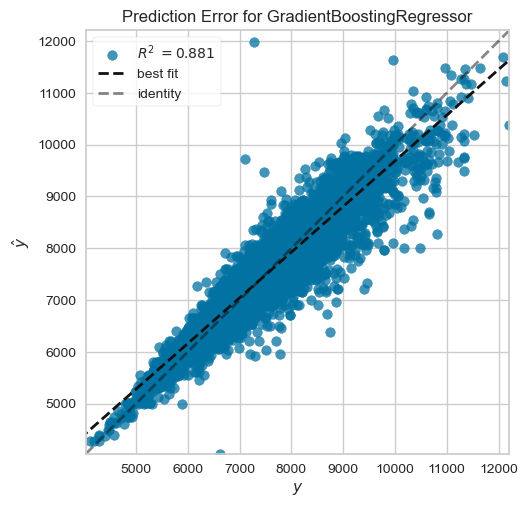

In [36]:
plot_model(best_model, plot='error')

In [37]:
tuned_best_model = exp2.tune_model(best_model, n_iter=50, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,296.7228,171769.2605,414.4506,0.8805,0.0527,0.0390
1,292.8325,156268.0446,395.3075,0.8908,0.0506,0.0388
2,308.2285,180905.4508,425.3298,0.8654,0.0539,0.0403
3,295.2225,158986.4831,398.7311,0.8830,0.0508,0.0389
4,309.2089,180071.1473,424.3479,0.8846,0.0534,0.0403
5,311.6312,198182.7856,445.1773,0.8628,0.0564,0.0408
6,318.3035,193417.6696,439.7928,0.8759,0.0552,0.0411
7,296.5644,180861.2111,425.2778,0.8766,0.0534,0.0386
8,296.3673,158275.7982,397.8389,0.8940,0.0511,0.0389


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [39]:
exp2.predict_model(tuned_best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,300.7244,175415.2432,418.8260,0.8810,0.0528,0.0392


,płeć_encoded,wiek,5 km Tempo,Czas,prediction_label
13950,1,35.0,5.626667,7261.0,7412.272951
14965,0,28.0,5.996666,7594.0,7973.638099
4782,1,33.0,5.310000,7463.0,6990.981073
1558,1,45.0,4.813334,6306.0,6355.389450
12952,1,48.0,5.516667,7024.0,7256.491567
...,...,...,...,...,...
562,1,31.0,4.293334,5693.0,5693.010599
15309,1,35.0,6.040000,7702.0,8003.039015
11913,1,29.0,5.053333,6731.0,6666.295141
915,1,27.0,4.630000,5976.0,6079.552713


In [41]:
final_model = exp2.finalize_model(best_model)

In [42]:
exp2.save_model(final_model, 'Gradient_Regressor_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['wiek', 'płeć_encoded',
                                              '5 km Tempo'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
                  GradientBoostingRegressor(random_state=123))]),
 'Gradient_Regressor_pipeline.pkl')

In [43]:
with open('Gradient_Regressor_pipeline.pkl', 'rb') as f:
    s3.upload_fileobj(f, BUCKET_NAME, 'Gradient_Regressor_pipeline.pkl')